BERT (Bidirectional Encoder Representations from Transformers)
This Colab is an extension of the steps presented in the TensorFlow tutorial: Classify text with BERT. https://www.tensorflow.org/text/tutorials/classify_text_with_bert?fbclid=IwAR0FpVibHdeT7yq_GHjdXrXA4F5JJtCTB1lUwIFd6oZ_KNx99aVhTTzv7us#the_preprocessing_model

Install latest supported version of tensorflow_text and tf-models-official

In [ ]:
!pip install -q -U "tensorflow-text==2.11.*"
!pip install -q tf-models-official==2.11.0
# there is an ERROR for some reason (version compatibility)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.3 MB/s eta 0:00:00
  

In [ ]:
# COMMON IMPORTS
import os # to use operating system
import shutil # file operations
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text # to preprocess natural language
from official.nlp import optimization  # for AdamW optimizer

tf.get_logger().setLevel('ERROR')

%matplotlib inline
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#Task 1 - Acquire and Preprocess the IMDB Data
The data was aquired from [this source](http://ai.stanford.edu/~amaas/data/sentiment/)


## Task 1.1 - Download the data
---


In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# file name, original url, to be extracted, store cached files in current location
IMDB_dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  extract=True, cache_dir='.',
                                  cache_subdir='')

84125825/84125825 [==============================] - 2s 0us/step


Clean up useless folders

In [ ]:
IMDB_dataset_dir = os.path.join(os.path.dirname(IMDB_dataset), 'aclImdb')

# Remove aclImdb/train/unsup
training_dir = os.path.join(IMDB_dataset_dir, 'train')
if (os.path.exists(os.path.join(training_dir, 'unsup'))) :  
  shutil.rmtree(os.path.join(training_dir, 'unsup'))
  
#Remove ./sample_data
if (os.path.exists(os.path.join(os.path.dirname(IMDB_dataset), 'sample_data/'))) :  
  shutil.rmtree(os.path.join(os.path.dirname(IMDB_dataset), 'sample_data/'))


From README.txt:

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg).

Let's extract the positive and training data and vectorize them, as well as the test data, to give us the following arrays: 

- `x_train_pos` - the positive training reviews
- `x_train_neg` - the negative training reviews

- `x_test_pos` - the postive reviews for testing
- `x_test_neg` - the negative reviews for testing

## Task 1.2 - Creating the Datasets

The next section consists of creating the datasets for the model as well as visualizing the input data. 

### Task 1.2.1 - Creating the train, validation, and test datasets

The 25k training instances are separated into training and validation sets to allow for fine-tuning. The 25k testing instances will be used to get an accurate measure of the performance in the end, to compare with the Naive Bayes implementations. 

In [ ]:
# To optimize the performances of the input pipeline
# computational efficiency, CPU vs GPU, etc.
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32 # default value
randomSeed = 32
validation_split = 0.2; #80/20 split
class_names = ['neg', 'pos']


# Generate a dataset from files

# directory of the data, inferred labels from directory structure, 
# int labels for simplification, default batch size, shuffle instances, 
# random seed for shuffling, 20% set aside for validation,
# use training dataset, do not use symlinks
training_dataset = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    batch_size=batch_size,
    max_length=None,
    shuffle=True,
    seed=randomSeed,
    validation_split=validation_split,
    subset='training',
    follow_links=False
    )
validation_dataset = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    class_names=class_names,
    batch_size=batch_size,
    shuffle=True,
    seed=randomSeed,
    validation_split=validation_split,
    subset='validation',
    )
test_dataset = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    class_names=class_names,
    batch_size=batch_size,
    )

# Cache the instances of the datasets
# To improve performance, prefetch elements dynamically
training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


We can clearly see that each element in the datasets is composed of batch_size number of instances, i.e. 32 movie reviews and their label.

In [ ]:
print('Training Dataset Shape: ', tf.data.experimental.cardinality(training_dataset))
print('Validation Dataset Shape: ', tf.data.experimental.cardinality(validation_dataset))
print('Test Dataset Shape: ', tf.data.experimental.cardinality(test_dataset))

Training Dataset Shape:  tf.Tensor(625, shape=(), dtype=int64)
Validation Dataset Shape:  tf.Tensor(157, shape=(), dtype=int64)
Test Dataset Shape:  tf.Tensor(782, shape=(), dtype=int64)


### Task 1.2.2 - Visualize intances

Some reviews can be viewed to confirm the datasets are correct.

In [ ]:
# Batch size subset of instances
# the 'b' in front of the printed string indicates
# byte string literal (ASCII-encoded)
i = 0
for texts, labels in training_dataset.take(1):
  print('Training Texts: ', texts.shape)
  print('Training Labels: ', labels.shape)
  print(f'Review: {texts.numpy()[i]}')
  label = labels.numpy()[i]
  print(f'Label : {label} ({class_names[label]})')

for texts, labels in validation_dataset.take(1):
  print('Validation Texts: ', texts.shape)
  print('Validation Labels: ', labels.shape)
  print(f'Review: {texts.numpy()[i]}')
  label = labels.numpy()[i]
  print(f'Label : {label} ({class_names[label]})')

for texts, labels in test_dataset.take(1):
  print('Test Texts: ', texts.shape)
  print('Test Labels: ', labels.shape)
  print(f'Review: {texts.numpy()[i]}')
  label = labels.numpy()[i]
  print(f'Label : {label} ({class_names[label]})')

Training Texts:  (32,)
Training Labels:  (32,)
Review: b'Okay, my title is kinda lame, and almost sells this flick short. I remember watching Siskel & Ebert in \'94 talking about this movie, and then playing a clip or two. Not being a rap-conscious guy (although I could identify Snoop Dogg, Vanilla Ice, and MC Hammer music), I wasn\'t much interested when they started talking about the film. But then, S&E showed the scene where the band explains how they picked their name (using some "shady" logic and a bunch of "made up" facts), and then another scene where the band, and their rival band, both visit a school to promote getting involved (and, of course, NWH comes up with some "info" about how the rival band leader is a loser because he got good grades in school and was on the yearbook committee). So I filed it away that I should see this movie.<br /><br />A couple of years later, this thing shows up on HBO and I recorded it, only to laugh my butt off for hours. Yes, it has a "Spinal Ta

## Task 1.3 - Preprocessing 
The preprocessing steps transforms texts into numeric tokens that can be inputed to the BERT model. The TensorFlow tutorial suggest that a good compromise between model size and accuracy could be to use ALBERT (A lite BERT) introduced by the paper https://arxiv.org/abs/1909.11942.

### Task 1.3.1 - Simple Preprocessing

The preprocessing documentation for ALBERT can be found here. https://tfhub.dev/tensorflow/albert_en_preprocess/3

In [ ]:
ALBERT_preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/albert_en_preprocess/3")

In [ ]:
review_test = ['I really enjoyed this movie. This is a great movie.']
preprocessed_review = ALBERT_preprocessor(tf.constant(review_test))

print(f'Keys : {list(preprocessed_review.keys())}')
print(f'Input Word Ids Shape : {preprocessed_review["input_word_ids"].shape}')
print(f'Input Mask Shape : {preprocessed_review["input_mask"].shape}')
print(f'Input Type Shape : {preprocessed_review["input_type_ids"].shape}')
print(f'Word Ids : {preprocessed_review["input_word_ids"]}')
print(f'Input Mask : {preprocessed_review["input_mask"]}')
print(f'Type Ids : {preprocessed_review["input_type_ids"]}')

Keys : ['input_type_ids', 'input_word_ids', 'input_mask']
Input Word Ids Shape : (1, 128)
Input Mask Shape : (1, 128)
Input Type Shape : (1, 128)
Word Ids : [[   2   31  510 4410   48 1308    9   48   25   21  374 1308    9    3
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 

The preprocessing output:
 `input_word_ids`, `input_mask`, and `input_type_ids`. The default length is 128 tokens.

*   `input_word_ids`: Unique IDs for individual words
*   `input_mask`: starts with 'CLF' and ends with 'SEP' tokens, length is the number of words in the sentence plus 2 as '1's and the rest padded with '0's, Tensor shape (number of sentences, 128 tokens default)
*   `input_type_ids`: IDs for multiple sentences array
https://www.analyticsvidhya.com/blog/2021/08/pratically-demistifying-bert-language-representation-model/


ALBERT output for the previous example.

In [ ]:
ALBERT_model = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3")

review_results = ALBERT_model(preprocessed_review)

print(f'Pooled Outputs Shape:{review_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{review_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{review_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{review_results["sequence_output"][0, :12]}')
print(f'Encoder Outputs Values:{review_results["encoder_outputs"]}')

Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.4824215  -0.48958823  0.91941845 -0.7592791  -0.6520462  -0.9849831
  0.50297415 -0.4963191   0.5299236  -0.9997832   0.96991295  0.48711577]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.7281914   0.8781848   0.16582295 ...  0.5804402  -0.7747874
   1.0741023 ]
 [ 0.50573933 -0.13009012 -0.9341378  ...  0.3025985   1.2317924
  -0.11359249]
 [ 0.15946656  0.85204965  0.7793206  ...  2.1386402  -0.8611943
   0.12516165]
 ...
 [ 0.6360275   0.8871503  -0.41895452 ...  0.50746     1.2881199
  -0.9487667 ]
 [ 0.5877834   0.8713627  -0.43280107 ...  0.5879551   1.3178108
  -0.86494434]
 [ 0.5700482   0.8878382  -0.36879683 ...  0.5655868   1.3057015
  -0.9012889 ]]
Encoder Outputs Values:[<tf.Tensor: shape=(1, 128, 768), dtype=float32, numpy=
array([[[ 1.3130716 ,  0.5662927 ,  1.021032  , ..., -0.00829321,
         -0.16340116, -0.7060429 ],
        [-0.07590938, -0.19023103,  0.02626829, ...,  0.57547486,
        

The encoding output:
 `pooled_output`, `sequence_output`, and `encoder_outputs` where the default number of hidden units is 728 and the default length is 128 tokens.

*   `pooled_output`: Embeddings for the entire sequence or review, size: (number of sequences, number of hidden units), values carry contextual meaning
*   `sequence_output`: Embeddings of individual words in the sequence, size: (number of sequences, max number of tokens, number of hidden units
*   `encoder_outputs`: intermediate activations of transformer block, same size as `sequence_output`

This description of the encoding output was taken from the previous link.

# Task 2 - ALBERT Model

This section consists of defining the ALBERT implementation.


## Task 2.1 - ALBERT Implementation

https://tfhub.dev/tensorflow/albert_en_base/3

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie_reviews (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_type_ids':   0           ['movie_reviews[0][0]']          
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

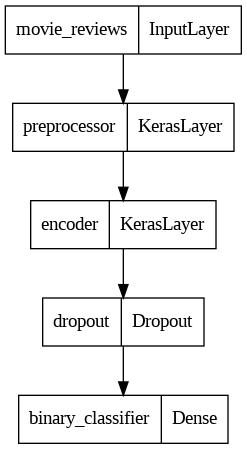

In [ ]:
def build_ALBERT_model(dropout_rate=0.1, trainable=True):
  movie_reviews = tf.keras.layers.Input(shape=(), dtype=tf.string, name='movie_reviews')
  preprocessor = hub.KerasLayer("http://tfhub.dev/tensorflow/albert_en_preprocess/3", name='preprocessor')
  encoder_inputs = preprocessor(movie_reviews)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3", trainable=trainable, name='encoder')
  outputs = encoder(encoder_inputs)
  # either pooled_output or sequence_output can be used for further model building
  pooled_output = outputs['pooled_output']
  dropout_layer = tf.keras.layers.Dropout(dropout_rate, name='dropout')(pooled_output)
  classify_layer = tf.keras.layers.Dense(1, activation=None, name='binary_classifier')(dropout_layer)
  return tf.keras.Model(movie_reviews, classify_layer)

ALBERT_model = build_ALBERT_model()
ALBERT_model.summary()
tf.keras.utils.plot_model(ALBERT_model)

Further Investigate the Architecture of the ALBERT
Code from https://stackoverflow.com/questions/61996588/is-there-any-way-to-access-layers-in-tensorflow-hub-keraslayer-object

In [ ]:
print("Thickness of the model:", len(ALBERT_model.weights))
print ("{:<80} {:<20} {:<10}".format('Layer','Shape','Type'))

for i in range(len(ALBERT_model.weights)):
    model_weights_raw_string = str(ALBERT_model.weights[i])
    model_weights_wo_weights = model_weights_raw_string.split(", numpy", 1)[0]
    dtype = model_weights_wo_weights.split(" dtype=")[1]
    shape = model_weights_wo_weights.split(" shape=")[1].split(" dtype=")[0]
    
    print ("{:<80} {:<20} {:<10}".format(ALBERT_model.weights[i].name, shape, dtype))

Thickness of the model: 27
Layer                                                                            Shape                Type      
word_embeddings/embeddings:0                                                     (30000, 128)         float32   
position_embedding/embeddings:0                                                  (512, 128)           float32   
type_embeddings/embeddings:0                                                     (2, 128)             float32   
embeddings/layer_norm/gamma:0                                                    (128,)               float32   
embeddings/layer_norm/beta:0                                                     (128,)               float32   
embedding_projection/kernel:0                                                    (128, 768)           float32   
embedding_projection/bias:0                                                      (768,)               float32   
transformer/self_attention/query/kernel:0                            

Verify that the model works on previous toy example.

In [ ]:
review_results = ALBERT_model(tf.constant(review_test))
print(tf.sigmoid(review_results))

tf.Tensor([[0.6682586]], shape=(1, 1), dtype=float32)


## Task 2.2 - ALBERT Training

Since binary classification is performed, the Binary Cross Entropy Loss Function is ideal. Additionally, accuracy is the benchmark metric to compare Naive Bayes and ALBERT model. With hindsight from the experiment section, the best parameter is 2e-5 for the learning and 0.1 for the dropout rate.

In [ ]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy = tf.metrics.BinaryAccuracy()

The optimizer for the first BERT implementation was Adam with weight decay. To follow the original procedure, `AdamW` is used.

In [ ]:
def createBERTOptimizer(training_dataset, epochs=5, learning_rate=2e-5):
  # epochs = epochs # arbitrary number, look for early stopping and overfitting agains validation set
  warmup_rate = 0.1
  steps_per_epoch = tf.data.experimental.cardinality(training_dataset).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(warmup_rate*num_train_steps)

  return optimization.create_optimizer(init_lr=learning_rate, # eventually test with 5e-5, 3e-5, and 2e-5 to chose the best
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
    
optimizer = createBERTOptimizer(training_dataset)

Training the model

In [ ]:
epochs = 5
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model.compile(optimizer=optimizer,
                         loss=loss_function,
                         metrics=accuracy)
# training dataset, against validation dataset, number of epochs
history = ALBERT_model.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 813s 1s/step - loss: 0.3940 - binary_accuracy: 0.8099 - val_loss: 0.2919 - val_binary_accuracy: 0.8644
Epoch 2/5
625/625 [==============================] - 803s 1s/step - loss: 0.2533 - binary_accuracy: 0.8955 - val_loss: 0.3222 - val_binary_accuracy: 0.8718
Epoch 3/5
625/625 [==============================] - 801s 1s/step - loss: 0.1629 - binary_accuracy: 0.9412 - val_loss: 0.4047 - val_binary_accuracy: 0.8844
Epoch 4/5
625/625 [==============================] - 802s 1s/step - loss: 0.0980 - binary_accuracy: 0.9705 - val_loss: 0.5597 - val_binary_accuracy: 0.8752
Epoch 5/5
625/625 [==============================] - 801s 1s/step - loss: 0.0525 - binary_accuracy: 0.9872 - val_loss: 0.6210 - val_binary_accuracy: 0.8846


# Task 3 - ALBERT Model Performances

This section consists of analizing ALBERT performances on the IMDB dataset.

## Task 3.1 - ALBERT Training and Validation Performances

Get the metrics to be plotted.

In [ ]:
history_dict = history.history
print(history_dict.keys())

training_accuracy = history_dict['binary_accuracy']
validation_accuracy = history_dict['val_binary_accuracy']
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

# to not lose values due to long training times
print('Validation Accuracy: ', validation_accuracy)
print('Training Accuracy: ', training_accuracy)
print('Validation Loss: ', validation_loss)
print('Training Loss: ', training_loss)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Validation Accuracy:  [0.8644000291824341, 0.8718000054359436, 0.8844000101089478, 0.8751999735832214, 0.8845999836921692]
Training Accuracy:  [0.8099499940872192, 0.8955000042915344, 0.9412000179290771, 0.9704999923706055, 0.9872499704360962]
Validation Loss:  [0.2918992042541504, 0.322229266166687, 0.4047052562236786, 0.5597213506698608, 0.6209730505943298]
Training Loss:  [0.394018292427063, 0.2533009648323059, 0.16292229294776917, 0.097989521920681, 0.052500490099191666]


### Task 3.1.1 - Loss Plot

The trainng and validation losses are plotted against the number of epochs.

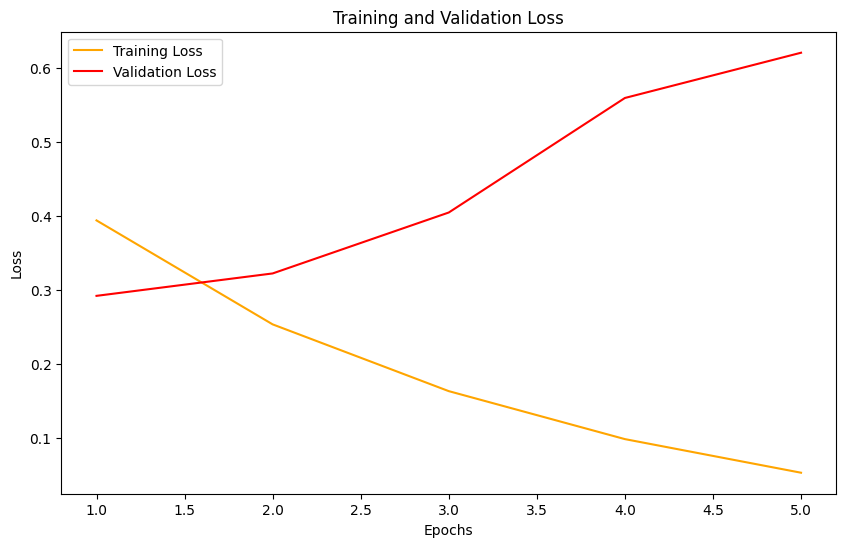

In [ ]:
def plotLoss(training_loss, validation_loss):
  epochs = range(1, len(training_loss) + 1)
  fig = plt.figure(figsize=(10, 6))
  fig.tight_layout()
  plt.plot(epochs, training_loss, 'orange', label='Training Loss')
  plt.plot(epochs, validation_loss, 'red', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

plotLoss(training_loss, validation_loss)

### Task 3.1.2 - Accuracy Plot

The trainng and validation accuracies are plotted against the number of epochs.

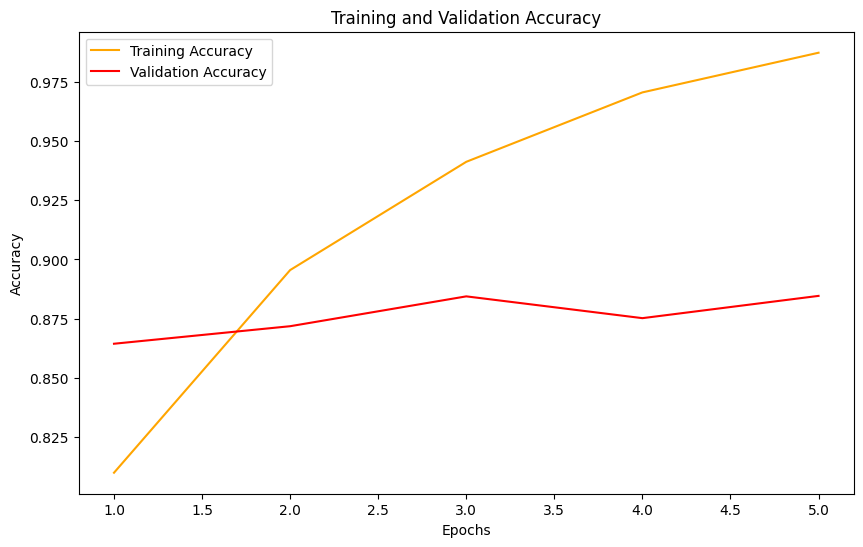

In [ ]:
def plotAccuracy(training_accuracy, validation_accuracy):
  epochs = range(1, len(training_accuracy) + 1)
  fig = plt.figure(figsize=(10, 6))
  fig.tight_layout()
  plt.plot(epochs, training_accuracy, 'orange', label='Training Accuracy')
  plt.plot(epochs, validation_accuracy, 'red', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

plotAccuracy(training_accuracy, validation_accuracy)

## Task 3.2 - ALBERT Test Performances

In [ ]:
loss, accuracy = ALBERT_model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 300s 384ms/step - loss: 0.6105 - binary_accuracy: 0.8878
Loss: 0.6104608774185181
Accuracy: 0.8878399729728699


#Task 4 - Experiements

This section regroups experiments performed on the model.

"For binary classification, the model worked well with adam optimizer, 32 batch size, 3e-5 learning rate, 1e-08 epsilon, 128 maximum sequence length, and binary cross entropy loss." https://scholarworks.uark.edu/cgi/viewcontent.cgi?article=6318&context=etd 

## Task 4.1 - Optimal Learning Rates for ALBERT

To follow the original BERT paper, the learning rates: 5e-5, 3e-5, and 2e-5, are tested to find the best one for the transfer learning exercise.

### Task 4.1.1 - Learning Rate of 5e-5

In [ ]:
epochs = 5
loss_function_411 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_411 = tf.metrics.BinaryAccuracy()
optimizer_411 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=5e-5)
ALBERT_model_411 = build_ALBERT_model()
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_411.compile(optimizer=optimizer_411,
                         loss=loss_function_411,
                         metrics=accuracy_411)
# training dataset, against validation dataset, number of epochs
history_411 = ALBERT_model_411.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)


Epoch 1/5
625/625 [==============================] - 808s 1s/step - loss: 0.4101 - binary_accuracy: 0.8079 - val_loss: 0.3109 - val_binary_accuracy: 0.8484
Epoch 2/5
625/625 [==============================] - 770s 1s/step - loss: 0.2775 - binary_accuracy: 0.8827 - val_loss: 0.3000 - val_binary_accuracy: 0.8754
Epoch 3/5
625/625 [==============================] - 768s 1s/step - loss: 0.1747 - binary_accuracy: 0.9364 - val_loss: 0.3666 - val_binary_accuracy: 0.8800
Epoch 4/5
625/625 [==============================] - 770s 1s/step - loss: 0.0998 - binary_accuracy: 0.9712 - val_loss: 0.5971 - val_binary_accuracy: 0.8762
Epoch 5/5
625/625 [==============================] - 768s 1s/step - loss: 0.0466 - binary_accuracy: 0.9883 - val_loss: 0.6561 - val_binary_accuracy: 0.8866


To make sure values are not lost.

In [ ]:
print('Validation Accuracy: ', history_411.history['val_binary_accuracy'])
print('Training Accuracy: ', history_411.history['binary_accuracy'])
print('Validation Loss: ', history_411.history['val_loss'])
print('Training Loss: ', history_411.history['loss'])

Validation Accuracy:  [0.8483999967575073, 0.8754000067710876, 0.8799999952316284, 0.8762000203132629, 0.8866000175476074]
Training Accuracy:  [0.8079000115394592, 0.8827000260353088, 0.9363999962806702, 0.9711999893188477, 0.988349974155426]
Validation Loss:  [0.31091126799583435, 0.30003124475479126, 0.3665531277656555, 0.5971121788024902, 0.6560526490211487]
Training Loss:  [0.4101330637931824, 0.27750080823898315, 0.17465318739414215, 0.09980486333370209, 0.04664717987179756]


### Task 4.1.2 - Learning Rate of 3e-5

In [ ]:
epochs = 5
loss_function_412 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_412 = tf.metrics.BinaryAccuracy()
optimizer_412 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=3e-5)
ALBERT_model_412 = build_ALBERT_model()
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_412.compile(optimizer=optimizer_412,
                         loss=loss_function_412,
                         metrics=accuracy_412)
# training dataset, against validation dataset, number of epochs
history_412 = ALBERT_model_412.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)


Epoch 1/5
625/625 [==============================] - 813s 1s/step - loss: 0.3969 - binary_accuracy: 0.8073 - val_loss: 0.3028 - val_binary_accuracy: 0.8474
Epoch 2/5
625/625 [==============================] - 802s 1s/step - loss: 0.2716 - binary_accuracy: 0.8876 - val_loss: 0.2953 - val_binary_accuracy: 0.8716
Epoch 3/5
625/625 [==============================] - 800s 1s/step - loss: 0.1799 - binary_accuracy: 0.9341 - val_loss: 0.3927 - val_binary_accuracy: 0.8796
Epoch 4/5
625/625 [==============================] - 801s 1s/step - loss: 0.1057 - binary_accuracy: 0.9690 - val_loss: 0.5281 - val_binary_accuracy: 0.8802
Epoch 5/5
625/625 [==============================] - 801s 1s/step - loss: 0.0565 - binary_accuracy: 0.9865 - val_loss: 0.6087 - val_binary_accuracy: 0.8884


In [ ]:
print('Validation Accuracy: ', history_412.history['val_binary_accuracy'])
print('Training Accuracy: ', history_412.history['binary_accuracy'])
print('Validation Loss: ', history_412.history['val_loss'])
print('Training Loss: ', history_412.history['loss'])

Validation Accuracy:  [0.8474000096321106, 0.8715999722480774, 0.8795999884605408, 0.8802000284194946, 0.8884000182151794]
Training Accuracy:  [0.8072999715805054, 0.8876000046730042, 0.934149980545044, 0.968999981880188, 0.986549973487854]
Validation Loss:  [0.3027639091014862, 0.2953025996685028, 0.3926825225353241, 0.528059184551239, 0.6087433695793152]
Training Loss:  [0.39691534638404846, 0.2715901732444763, 0.1799367070198059, 0.10572950541973114, 0.05652675777673721]


### Task 4.1.3 - Learning Rate of 2e-5

In [ ]:
epochs = 5
loss_function_413 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_413 = tf.metrics.BinaryAccuracy()
optimizer_413 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=2e-5)
ALBERT_model_413 = build_ALBERT_model()
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_413.compile(optimizer=optimizer_413,
                         loss=loss_function_413,
                         metrics=accuracy_413)
# training dataset, against validation dataset, number of epochs
history_413 = ALBERT_model_413.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 770s 1s/step - loss: 0.3949 - binary_accuracy: 0.8073 - val_loss: 0.2880 - val_binary_accuracy: 0.8702
Epoch 2/5
625/625 [==============================] - 752s 1s/step - loss: 0.2455 - binary_accuracy: 0.8996 - val_loss: 0.2850 - val_binary_accuracy: 0.8682
Epoch 3/5
625/625 [==============================] - 778s 1s/step - loss: 0.1604 - binary_accuracy: 0.9438 - val_loss: 0.3809 - val_binary_accuracy: 0.8710
Epoch 4/5
625/625 [==============================] - 752s 1s/step - loss: 0.0964 - binary_accuracy: 0.9709 - val_loss: 0.5183 - val_binary_accuracy: 0.8770
Epoch 5/5
625/625 [==============================] - 742s 1s/step - loss: 0.0506 - binary_accuracy: 0.9876 - val_loss: 0.6154 - val_binary_accuracy: 0.8878


To make sure values are not lost.

In [ ]:
print('Validation Accuracy: ', history_413.history['val_binary_accuracy'])
print('Training Accuracy: ', history_413.history['binary_accuracy'])
print('Validation Loss: ', history_413.history['val_loss'])
print('Training Loss: ', history_413.history['loss'])

Validation Accuracy:  [0.870199978351593, 0.8682000041007996, 0.8709999918937683, 0.8769999742507935, 0.8877999782562256]
Training Accuracy:  [0.8072500228881836, 0.8996000289916992, 0.9438499808311462, 0.9708999991416931, 0.9875500202178955]
Validation Loss:  [0.28803446888923645, 0.2850246727466583, 0.3809053897857666, 0.5183202028274536, 0.6153738498687744]
Training Loss:  [0.3948582112789154, 0.24552813172340393, 0.1603611409664154, 0.09644987434148788, 0.050585757941007614]


### Task 4.1.3 - Show Results

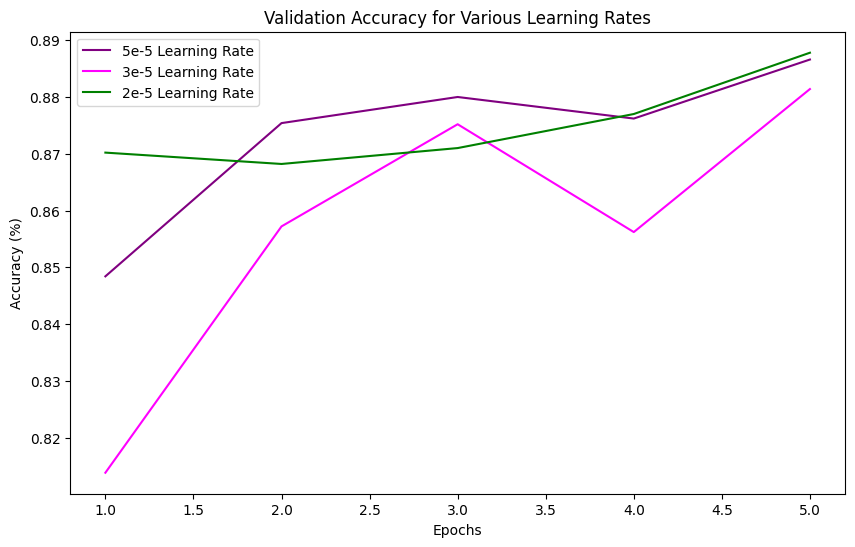

In [ ]:
def plotValidationAccuracy(val_regular, val_411, val_412):
  epochs = range(1, len(val_regular) + 1)
  fig = plt.figure(figsize=(10, 6))
  fig.tight_layout()
  plt.plot(epochs, val_411, 'purple', label='5e-5 Learning Rate')
  plt.plot(epochs, val_regular, 'magenta', label='3e-5 Learning Rate')
  plt.plot(epochs, val_412, 'green', label='2e-5 Learning Rate')
  plt.title('Validation Accuracy for Various Learning Rates')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.show()

# from previous experiments
val_regular = [0.8137999773025513, 0.857200026512146, 0.8751999735832214, 0.8561999797821045, 0.8813999891281128]
val_411 = [0.8483999967575073, 0.8754000067710876, 0.8799999952316284, 0.8762000203132629, 0.8866000175476074]
val_412 = [0.870199978351593, 0.8682000041007996, 0.8709999918937683, 0.8769999742507935, 0.8877999782562256]
plotValidationAccuracy(val_regular, val_411, val_412)

2e-5 is our choice

## Task 4.2 - Optimal Dropout Rate for ALBERT

The original BERT and the ALBERT used for the classification task were trained with "dropout probability of 0.1 on all layers." https://arxiv.org/pdf/1810.04805.pdf 

"Dropout [27] is found to be a good regularizer in text classification [11, 21]." "A significant dropout (0.5 to 0.7) may be required if the source dataset is highly suitable for a target dataset." https://arxiv.org/pdf/1801.06480.pdf 

We are looking at the effect of dropout on the classification layer in particular.


### Task 4.2.1 - Dropout Rate of 0%

In [ ]:
epochs = 5
loss_function_421 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_421 = tf.metrics.BinaryAccuracy()
optimizer_421 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=2e-5)
ALBERT_model_421 = build_ALBERT_model(dropout_rate=0.)
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_421.compile(optimizer=optimizer_421,
                         loss=loss_function_421,
                         metrics=accuracy_421)
# training dataset, against validation dataset, number of epochs
history_421 = ALBERT_model_421.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 774s 1s/step - loss: 0.3852 - binary_accuracy: 0.8063 - val_loss: 0.2894 - val_binary_accuracy: 0.8766
Epoch 2/5
625/625 [==============================] - 753s 1s/step - loss: 0.2448 - binary_accuracy: 0.8971 - val_loss: 0.2902 - val_binary_accuracy: 0.8736
Epoch 3/5
625/625 [==============================] - 752s 1s/step - loss: 0.1581 - binary_accuracy: 0.9437 - val_loss: 0.4042 - val_binary_accuracy: 0.8824
Epoch 4/5
625/625 [==============================] - 781s 1s/step - loss: 0.0993 - binary_accuracy: 0.9714 - val_loss: 0.5784 - val_binary_accuracy: 0.8720
Epoch 5/5
625/625 [==============================] - 755s 1s/step - loss: 0.0525 - binary_accuracy: 0.9875 - val_loss: 0.6036 - val_binary_accuracy: 0.8878


In [ ]:
print('Validation Accuracy: ', history_421.history['val_binary_accuracy'])
print('Training Accuracy: ', history_421.history['binary_accuracy'])
print('Validation Loss: ', history_421.history['val_loss'])
print('Training Loss: ', history_421.history['loss'])

Validation Accuracy:  [0.8766000270843506, 0.8736000061035156, 0.8823999762535095, 0.871999979019165, 0.8877999782562256]
Training Accuracy:  [0.8062999844551086, 0.8971499800682068, 0.9436500072479248, 0.9713500142097473, 0.9874500036239624]
Validation Loss:  [0.28936243057250977, 0.29022592306137085, 0.40415048599243164, 0.5783505439758301, 0.6035981178283691]
Training Loss:  [0.3852202594280243, 0.24484850466251373, 0.1580655425786972, 0.09934423118829727, 0.05248935520648956]


### Task 4.2.2 - Dropout Rate of 20%

In [ ]:
epochs = 5
loss_function_422 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_422 = tf.metrics.BinaryAccuracy()
optimizer_422 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=2e-5)
ALBERT_model_422 = build_ALBERT_model(dropout_rate=0.2)
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_422.compile(optimizer=optimizer_422,
                         loss=loss_function_422,
                         metrics=accuracy_422)
# training dataset, against validation dataset, number of epochs
history_422 = ALBERT_model_422.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 767s 1s/step - loss: 0.4138 - binary_accuracy: 0.7957 - val_loss: 0.3032 - val_binary_accuracy: 0.8452
Epoch 2/5
625/625 [==============================] - 753s 1s/step - loss: 0.2592 - binary_accuracy: 0.8918 - val_loss: 0.2993 - val_binary_accuracy: 0.8710
Epoch 3/5
625/625 [==============================] - 782s 1s/step - loss: 0.1693 - binary_accuracy: 0.9364 - val_loss: 0.3781 - val_binary_accuracy: 0.8806
Epoch 4/5
625/625 [==============================] - 754s 1s/step - loss: 0.1065 - binary_accuracy: 0.9688 - val_loss: 0.6018 - val_binary_accuracy: 0.8678
Epoch 5/5
625/625 [==============================] - 749s 1s/step - loss: 0.0607 - binary_accuracy: 0.9844 - val_loss: 0.6273 - val_binary_accuracy: 0.8834


In [ ]:
print('Validation Accuracy: ', history_422.history['val_binary_accuracy'])
print('Training Accuracy: ', history_422.history['binary_accuracy'])
print('Validation Loss: ', history_422.history['val_loss'])
print('Training Loss: ', history_422.history['loss'])

Validation Accuracy:  [0.8452000021934509, 0.8709999918937683, 0.8805999755859375, 0.8677999973297119, 0.883400022983551]
Training Accuracy:  [0.7957000136375427, 0.8917999863624573, 0.9363999962806702, 0.96875, 0.9844499826431274]
Validation Loss:  [0.30317234992980957, 0.2993256151676178, 0.37808987498283386, 0.6017773151397705, 0.6272761225700378]
Training Loss:  [0.4138130843639374, 0.2591547667980194, 0.16930797696113586, 0.10650233179330826, 0.06072632968425751]


### Task 4.2.3 - Dropout Rate of 30%

In [ ]:
epochs = 5
loss_function_423 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_423 = tf.metrics.BinaryAccuracy()
optimizer_423 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=2e-5)
ALBERT_model_423 = build_ALBERT_model(dropout_rate=0.3)
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_423.compile(optimizer=optimizer_423,
                         loss=loss_function_423,
                         metrics=accuracy_423)
# training dataset, against validation dataset, number of epochs
history_423 = ALBERT_model_423.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 795s 1s/step - loss: 0.4323 - binary_accuracy: 0.7883 - val_loss: 0.3097 - val_binary_accuracy: 0.8570
Epoch 2/5
625/625 [==============================] - 754s 1s/step - loss: 0.2778 - binary_accuracy: 0.8809 - val_loss: 0.2822 - val_binary_accuracy: 0.8752
Epoch 3/5
625/625 [==============================] - 746s 1s/step - loss: 0.1791 - binary_accuracy: 0.9344 - val_loss: 0.3863 - val_binary_accuracy: 0.8776
Epoch 4/5
625/625 [==============================] - 752s 1s/step - loss: 0.1097 - binary_accuracy: 0.9689 - val_loss: 0.5229 - val_binary_accuracy: 0.8742
Epoch 5/5
625/625 [==============================] - 750s 1s/step - loss: 0.0593 - binary_accuracy: 0.9859 - val_loss: 0.5972 - val_binary_accuracy: 0.8834


In [ ]:
print('Validation Accuracy: ', history_423.history['val_binary_accuracy'])
print('Training Accuracy: ', history_423.history['binary_accuracy'])
print('Validation Loss: ', history_423.history['val_loss'])
print('Training Loss: ', history_423.history['loss'])

Validation Accuracy:  [0.8569999933242798, 0.8751999735832214, 0.8776000142097473, 0.8741999864578247, 0.883400022983551]
Training Accuracy:  [0.7882500290870667, 0.8808500170707703, 0.9343500137329102, 0.9688500165939331, 0.9859499931335449]
Validation Loss:  [0.30968987941741943, 0.2822343707084656, 0.38627418875694275, 0.5229432582855225, 0.5971590280532837]
Training Loss:  [0.43228915333747864, 0.2777560353279114, 0.1791493147611618, 0.10966169089078903, 0.05933269485831261]


### Task 4.2.4 - Dropout Rate of 40%

In [ ]:
epochs = 5
loss_function_424 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_424 = tf.metrics.BinaryAccuracy()
optimizer_424 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=2e-5)
ALBERT_model_424 = build_ALBERT_model(dropout_rate=0.4)
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_424.compile(optimizer=optimizer_424,
                         loss=loss_function_424,
                         metrics=accuracy_424)
# training dataset, against validation dataset, number of epochs
history_424 = ALBERT_model_424.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 772s 1s/step - loss: 0.4229 - binary_accuracy: 0.8016 - val_loss: 0.3069 - val_binary_accuracy: 0.8704
Epoch 2/5
625/625 [==============================] - 758s 1s/step - loss: 0.2592 - binary_accuracy: 0.8934 - val_loss: 0.2951 - val_binary_accuracy: 0.8740
Epoch 3/5
625/625 [==============================] - 785s 1s/step - loss: 0.1700 - binary_accuracy: 0.9395 - val_loss: 0.3840 - val_binary_accuracy: 0.8790
Epoch 4/5
625/625 [==============================] - 758s 1s/step - loss: 0.1119 - binary_accuracy: 0.9672 - val_loss: 0.5227 - val_binary_accuracy: 0.8796
Epoch 5/5
625/625 [==============================] - 758s 1s/step - loss: 0.0598 - binary_accuracy: 0.9855 - val_loss: 0.5931 - val_binary_accuracy: 0.8846


In [ ]:
print('Validation Accuracy: ', history_424.history['val_binary_accuracy'])
print('Training Accuracy: ', history_424.history['binary_accuracy'])
print('Validation Loss: ', history_424.history['val_loss'])
print('Training Loss: ', history_424.history['loss'])

Validation Accuracy:  [0.8704000115394592, 0.8740000128746033, 0.8790000081062317, 0.8795999884605408, 0.8845999836921692]
Training Accuracy:  [0.8016499876976013, 0.8933500051498413, 0.9394500255584717, 0.9672499895095825, 0.9854999780654907]
Validation Loss:  [0.3068668246269226, 0.29514747858047485, 0.383989542722702, 0.5227214694023132, 0.5930870175361633]
Training Loss:  [0.42288726568222046, 0.2592082917690277, 0.16997866332530975, 0.11190269887447357, 0.0598289854824543]


### Task 4.2.5 - Dropout Rate of 50%

In [ ]:
epochs = 5
loss_function_425 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_425 = tf.metrics.BinaryAccuracy()
optimizer_425 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=2e-5)
ALBERT_model_425 = build_ALBERT_model(dropout_rate=0.5)
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_425.compile(optimizer=optimizer_425,
                         loss=loss_function_425,
                         metrics=accuracy_425)
# training dataset, against validation dataset, number of epochs
history_425 = ALBERT_model_425.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 774s 1s/step - loss: 0.4462 - binary_accuracy: 0.7855 - val_loss: 0.2974 - val_binary_accuracy: 0.8520
Epoch 2/5
625/625 [==============================] - 757s 1s/step - loss: 0.2699 - binary_accuracy: 0.8882 - val_loss: 0.2729 - val_binary_accuracy: 0.8806
Epoch 3/5
625/625 [==============================] - 756s 1s/step - loss: 0.1806 - binary_accuracy: 0.9354 - val_loss: 0.3446 - val_binary_accuracy: 0.8876
Epoch 4/5
625/625 [==============================] - 757s 1s/step - loss: 0.1120 - binary_accuracy: 0.9677 - val_loss: 0.5049 - val_binary_accuracy: 0.8816
Epoch 5/5
625/625 [==============================] - 757s 1s/step - loss: 0.0636 - binary_accuracy: 0.9844 - val_loss: 0.6367 - val_binary_accuracy: 0.8838


In [ ]:
print('Validation Accuracy: ', history_425.history['val_binary_accuracy'])
print('Training Accuracy: ', history_425.history['binary_accuracy'])
print('Validation Loss: ', history_425.history['val_loss'])
print('Training Loss: ', history_425.history['loss'])

Validation Accuracy:  [0.8519999980926514, 0.8805999755859375, 0.8876000046730042, 0.881600022315979, 0.8838000297546387]
Training Accuracy:  [0.7855499982833862, 0.8881999850273132, 0.9354000091552734, 0.9677000045776367, 0.9844499826431274]
Validation Loss:  [0.29741865396499634, 0.2729422152042389, 0.34464791417121887, 0.504875898361206, 0.6367287039756775]
Training Loss:  [0.4462081491947174, 0.2699415385723114, 0.1806296557188034, 0.11200975626707077, 0.06361082196235657]


### Task 4.2.6 - Dropout Rate of 60%

In [ ]:
epochs = 5
loss_function_426 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_426 = tf.metrics.BinaryAccuracy()
optimizer_426 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=2e-5)
ALBERT_model_426 = build_ALBERT_model(dropout_rate=0.6)
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_426.compile(optimizer=optimizer_426,
                         loss=loss_function_426,
                         metrics=accuracy_426)
# training dataset, against validation dataset, number of epochs
history_426 = ALBERT_model_426.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 771s 1s/step - loss: 0.4707 - binary_accuracy: 0.7750 - val_loss: 0.2999 - val_binary_accuracy: 0.8716
Epoch 2/5
625/625 [==============================] - 758s 1s/step - loss: 0.2779 - binary_accuracy: 0.8857 - val_loss: 0.2916 - val_binary_accuracy: 0.8806
Epoch 3/5
625/625 [==============================] - 785s 1s/step - loss: 0.1790 - binary_accuracy: 0.9337 - val_loss: 0.3626 - val_binary_accuracy: 0.8796
Epoch 4/5
625/625 [==============================] - 756s 1s/step - loss: 0.1082 - binary_accuracy: 0.9683 - val_loss: 0.5461 - val_binary_accuracy: 0.8694
Epoch 5/5
625/625 [==============================] - 785s 1s/step - loss: 0.0598 - binary_accuracy: 0.9861 - val_loss: 0.6319 - val_binary_accuracy: 0.8838


In [ ]:
print('Validation Accuracy: ', history_426.history['val_binary_accuracy'])
print('Training Accuracy: ', history_426.history['binary_accuracy'])
print('Validation Loss: ', history_426.history['val_loss'])
print('Training Loss: ', history_426.history['loss'])

Validation Accuracy:  [0.8715999722480774, 0.8805999755859375, 0.8795999884605408, 0.8694000244140625, 0.8838000297546387]
Training Accuracy:  [0.7749500274658203, 0.885699987411499, 0.9337499737739563, 0.9683499932289124, 0.9861000180244446]
Validation Loss:  [0.29992374777793884, 0.2916484475135803, 0.3625619113445282, 0.546057939529419, 0.6318841576576233]
Training Loss:  [0.4707237780094147, 0.2778737545013428, 0.17903916537761688, 0.10819879174232483, 0.05975106731057167]


### Task 4.2.7 - Dropout Rate of 70%

In [ ]:
epochs = 5
loss_function_427 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_427 = tf.metrics.BinaryAccuracy()
optimizer_427 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=2e-5)
ALBERT_model_427 = build_ALBERT_model(dropout_rate=0.7)
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_427.compile(optimizer=optimizer_427,
                         loss=loss_function_427,
                         metrics=accuracy_427)
# training dataset, against validation dataset, number of epochs
history_427 = ALBERT_model_427.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 761s 1s/step - loss: 0.5028 - binary_accuracy: 0.7663 - val_loss: 0.2895 - val_binary_accuracy: 0.8734
Epoch 2/5
625/625 [==============================] - 773s 1s/step - loss: 0.2897 - binary_accuracy: 0.8799 - val_loss: 0.2802 - val_binary_accuracy: 0.8786
Epoch 3/5
625/625 [==============================] - 743s 1s/step - loss: 0.1986 - binary_accuracy: 0.9262 - val_loss: 0.3771 - val_binary_accuracy: 0.8656
Epoch 4/5
625/625 [==============================] - 743s 1s/step - loss: 0.1164 - binary_accuracy: 0.9651 - val_loss: 0.5161 - val_binary_accuracy: 0.8800
Epoch 5/5
625/625 [==============================] - 744s 1s/step - loss: 0.0711 - binary_accuracy: 0.9836 - val_loss: 0.6194 - val_binary_accuracy: 0.8856


In [ ]:
print('Validation Accuracy: ', history_427.history['val_binary_accuracy'])
print('Training Accuracy: ', history_427.history['binary_accuracy'])
print('Validation Loss: ', history_427.history['val_loss'])
print('Training Loss: ', history_427.history['loss'])

Validation Accuracy:  [0.8733999729156494, 0.878600001335144, 0.8655999898910522, 0.8799999952316284, 0.8855999708175659]
Training Accuracy:  [0.7663499712944031, 0.8798999786376953, 0.9261999726295471, 0.965149998664856, 0.9836000204086304]
Validation Loss:  [0.2895011603832245, 0.2801714539527893, 0.37713202834129333, 0.5161219835281372, 0.6193802952766418]
Training Loss:  [0.5027878880500793, 0.2896899878978729, 0.1986120045185089, 0.1163775771856308, 0.07114115357398987]


### Task 4.2.8 - Show Results

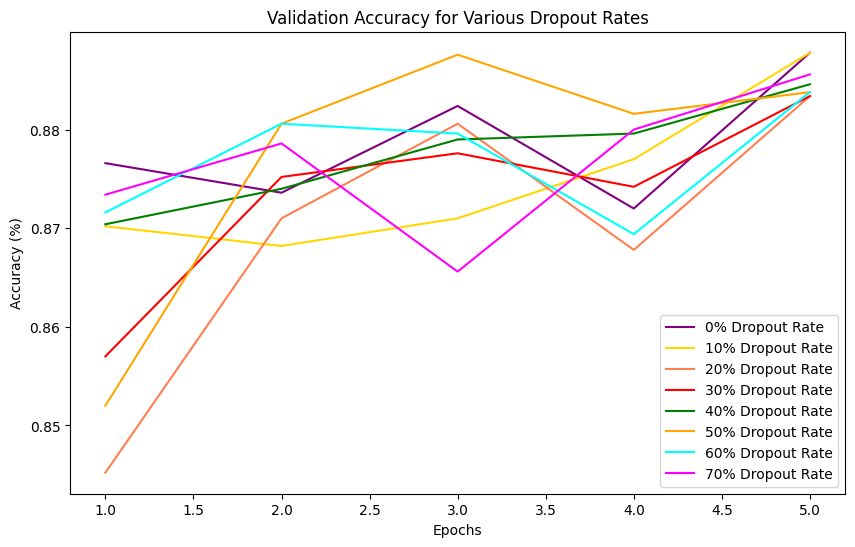

In [ ]:
# from previous experiments
val_421 = [0.8766000270843506, 0.8736000061035156, 0.8823999762535095, 0.871999979019165, 0.8877999782562256] # 0%
val_413 = [0.870199978351593, 0.8682000041007996, 0.8709999918937683, 0.8769999742507935, 0.8877999782562256] # 10%
val_422 = [0.8452000021934509, 0.8709999918937683, 0.8805999755859375, 0.8677999973297119, 0.883400022983551] # 20%
val_423 = [0.8569999933242798, 0.8751999735832214, 0.8776000142097473, 0.8741999864578247, 0.883400022983551] # 30%
val_424 = [0.8704000115394592, 0.8740000128746033, 0.8790000081062317, 0.8795999884605408, 0.8845999836921692] # 40%
val_425 = [0.8519999980926514, 0.8805999755859375, 0.8876000046730042, 0.881600022315979, 0.8838000297546387] # 50%
val_426 = [0.8715999722480774, 0.8805999755859375, 0.8795999884605408, 0.8694000244140625, 0.8838000297546387] # 60%
val_427 = [0.8733999729156494, 0.878600001335144, 0.8655999898910522, 0.8799999952316284, 0.8855999708175659] # 70%

# plot the results
epochs = range(1, len(val_421) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()
plt.plot(epochs, val_421, 'purple', label='0% Dropout Rate')
plt.plot(epochs, val_413, 'gold', label='10% Dropout Rate')
plt.plot(epochs, val_422, 'coral', label='20% Dropout Rate')
plt.plot(epochs, val_423, 'red', label='30% Dropout Rate')
plt.plot(epochs, val_424, 'green', label='40% Dropout Rate')
plt.plot(epochs, val_425, 'orange', label='50% Dropout Rate')
plt.plot(epochs, val_426, 'cyan', label='60% Dropout Rate')
plt.plot(epochs, val_427, 'magenta', label='70% Dropout Rate')
plt.title('Validation Accuracy for Various Dropout Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


10%

## Task 4.3 - Freezing the Weights of ALBERT

To better understand the effects of pre-training on external corpus, the pre-trained weights of ALBERT are frozen and only the classification layer is trained on the IMDB dataset. 

In [ ]:
ALBERT_model_43 = build_ALBERT_model(trainable=False)
ALBERT_model_43.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie_reviews (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_word_ids':   0           ['movie_reviews[0][0]']          
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

Training the Frozen Model

In [ ]:
epochs = 5
loss_function_43 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_43 = tf.metrics.BinaryAccuracy()
optimizer_43 = createBERTOptimizer(training_dataset, epochs=epochs, learning_rate=2e-5)
# AdamW, Binary Cross Entropy, Accuracy
ALBERT_model_43.compile(optimizer=optimizer_43,
                         loss=loss_function_43,
                         metrics=accuracy_43)
# training dataset, against validation dataset, number of epochs
history_43 = ALBERT_model_43.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 282s 433ms/step - loss: 0.7596 - binary_accuracy: 0.5051 - val_loss: 0.6930 - val_binary_accuracy: 0.5010
Epoch 2/5
625/625 [==============================] - 274s 438ms/step - loss: 0.7103 - binary_accuracy: 0.5084 - val_loss: 0.6895 - val_binary_accuracy: 0.5004
Epoch 3/5
625/625 [==============================] - 277s 443ms/step - loss: 0.7039 - binary_accuracy: 0.5088 - val_loss: 0.6874 - val_binary_accuracy: 0.5004
Epoch 4/5
625/625 [==============================] - 277s 444ms/step - loss: 0.7050 - binary_accuracy: 0.5096 - val_loss: 0.6862 - val_binary_accuracy: 0.5012
Epoch 5/5
625/625 [==============================] - 277s 444ms/step - loss: 0.7058 - binary_accuracy: 0.5078 - val_loss: 0.6858 - val_binary_accuracy: 0.5020


Testing the Frozen Model

In [ ]:
loss, accuracy = ALBERT_model_43.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 279s 356ms/step - loss: 0.6865 - binary_accuracy: 0.5027
Loss: 0.6865095496177673
Accuracy: 0.5026800036430359


## Task 4.4 - Attention matrix for ALBERT
Unfortunately, we could not find a way to output the attention matrix with TensorFlow. Nonetheless, we tried to replicate the ALBERT implementation in the best possible way using Hugging Face and output the attention matrix for some reviews.

## Task 4.4.1 - ALBERT with Hugging Face
The following code follows the procedure outlined in an official Hugging Face tutorial. https://huggingface.co/docs/transformers/tasks/sequence_classification 

Install required libraries

In [ ]:
!pip install transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

Importing the IMDB dataset

In [ ]:
from datasets import load_dataset

IMDB_dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Visualize the dataset

In [ ]:
print("IMDB dataset keys: ", IMDB_dataset.keys())
print("IMDB Training dataset size: ", IMDB_dataset['train'].shape)
print("IMDB Testing dataset size: ", IMDB_dataset['test'].shape)
print("Instance keys: ", IMDB_dataset['train'][0].keys())
print(IMDB_dataset['train'][0])

IMDB dataset keys:  dict_keys(['train', 'test', 'unsupervised'])
IMDB Training dataset size:  (25000, 2)
IMDB Testing dataset size:  (25000, 2)
Instance keys:  dict_keys(['text', 'label'])
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher,

Preprocess the data

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

In [ ]:
# Preprocess input with tokenizer
def preprocess_function(instances):
    return tokenizer(instances['text'], truncation=True)

tokenized_IMDB_dataset = IMDB_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

# Pad the input 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Load the metric

In [ ]:
import evaluate

accuracy = evaluate.load('accuracy')

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Map Labels and IDs

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

Load the ALBERT Model

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
# , output_attentions=True
ALBERT_model = AutoModelForSequenceClassification.from_pretrained(
    'albert-base-v2', num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

Setup Training

In [ ]:
batch_size = 16
learning_rate = 2e-5
epochs = 5
weight_decay = 0.004
warmup_ratio = 0.1

training_args = TrainingArguments(
    output_dir='albert',
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=ALBERT_model,
    args=training_args,
    train_dataset=tokenized_IMDB_dataset['train'],
    eval_dataset=tokenized_IMDB_dataset['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Train

In [ ]:
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.261000,0.233234,0.919800
2,0.197700,0.207606,0.938320
3,0.131300,0.254043,0.940480
4,0.064700,0.314994,0.941200
5,0.022400,0.369578,0.940880


TrainOutput(global_step=7815, training_loss=0.1466878178328638, metrics={'train_runtime': 16399.4176, 'train_samples_per_second': 7.622, 'train_steps_per_second': 0.477, 'total_flos': 2962595771497440.0, 'train_loss': 0.1466878178328638, 'epoch': 5.0})

## Task 4.4.2 - Attention Matrix

Find one correctly specified review and one incorrectly specified review

In [ ]:
# to only use CPU
ALBERT_model.to('cpu')

is_correctly_found = False
is_incorrectly_found = False

correctly_review = None
incorrectly_review = None

correctly_input = None
incorrectly_input = None

correctly_output = None
incorrectly_output = None

counter = 0
maxLength = 16
while not is_correctly_found or not is_incorrectly_found:
  review = IMDB_dataset['test'][counter]
  if  len(review['text'].split()) >= maxLength: 
    counter += 1
    continue 
  inputs = tokenizer(review['text'], return_tensors="pt")
  outputs = ALBERT_model(**inputs, output_attentions=True)
  label = review['label']
  predicted_label = outputs.logits.argmax().item()
  counter += 1
  # Correctly Classified
  if (not is_correctly_found and label == predicted_label):
     correctly_review = review
     correctly_input = inputs
     correctly_output = outputs
     is_correctly_found = True
  # Incorrectly Classified
  if (not is_incorrectly_found and label != predicted_label):
    incorrectly_review = review
    incorrectly_input = inputs
    incorrectly_output = outputs
    is_incorrectly_found = True

print('Correctly Classified Review: ', correctly_review)
print('ALBERT Output: ', correctly_output.logits.argmax().item())
print('Incorrectly Classified Review: ', incorrectly_review)
print('ALBERT Output: ', incorrectly_output.logits.argmax().item())

Correctly Classified Review:  {'text': 'Primary plot!Primary direction!Poor interpretation.', 'label': 0}
ALBERT Output:  0
Incorrectly Classified Review:  {'text': 'I hope this group of film-makers never re-unites.', 'label': 0}
ALBERT Output:  1


Visualize the Attention Matrix

The `visualize_token2token_scores` function was taken from https://captum.ai/tutorials/Bert_SQUAD_Interpret2

In [ ]:
def visualize_token2token_scores(scores_mat, all_tokens, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def print_attention_matrix(input, output, name) : 
  all_tokens = tokenizer.convert_ids_to_tokens(input.input_ids[0].detach().tolist())
  scores_mat = output.attentions[-1].squeeze().detach().numpy()
  print(name)
  visualize_token2token_scores(scores_mat, all_tokens)

Correctly Classified Instance


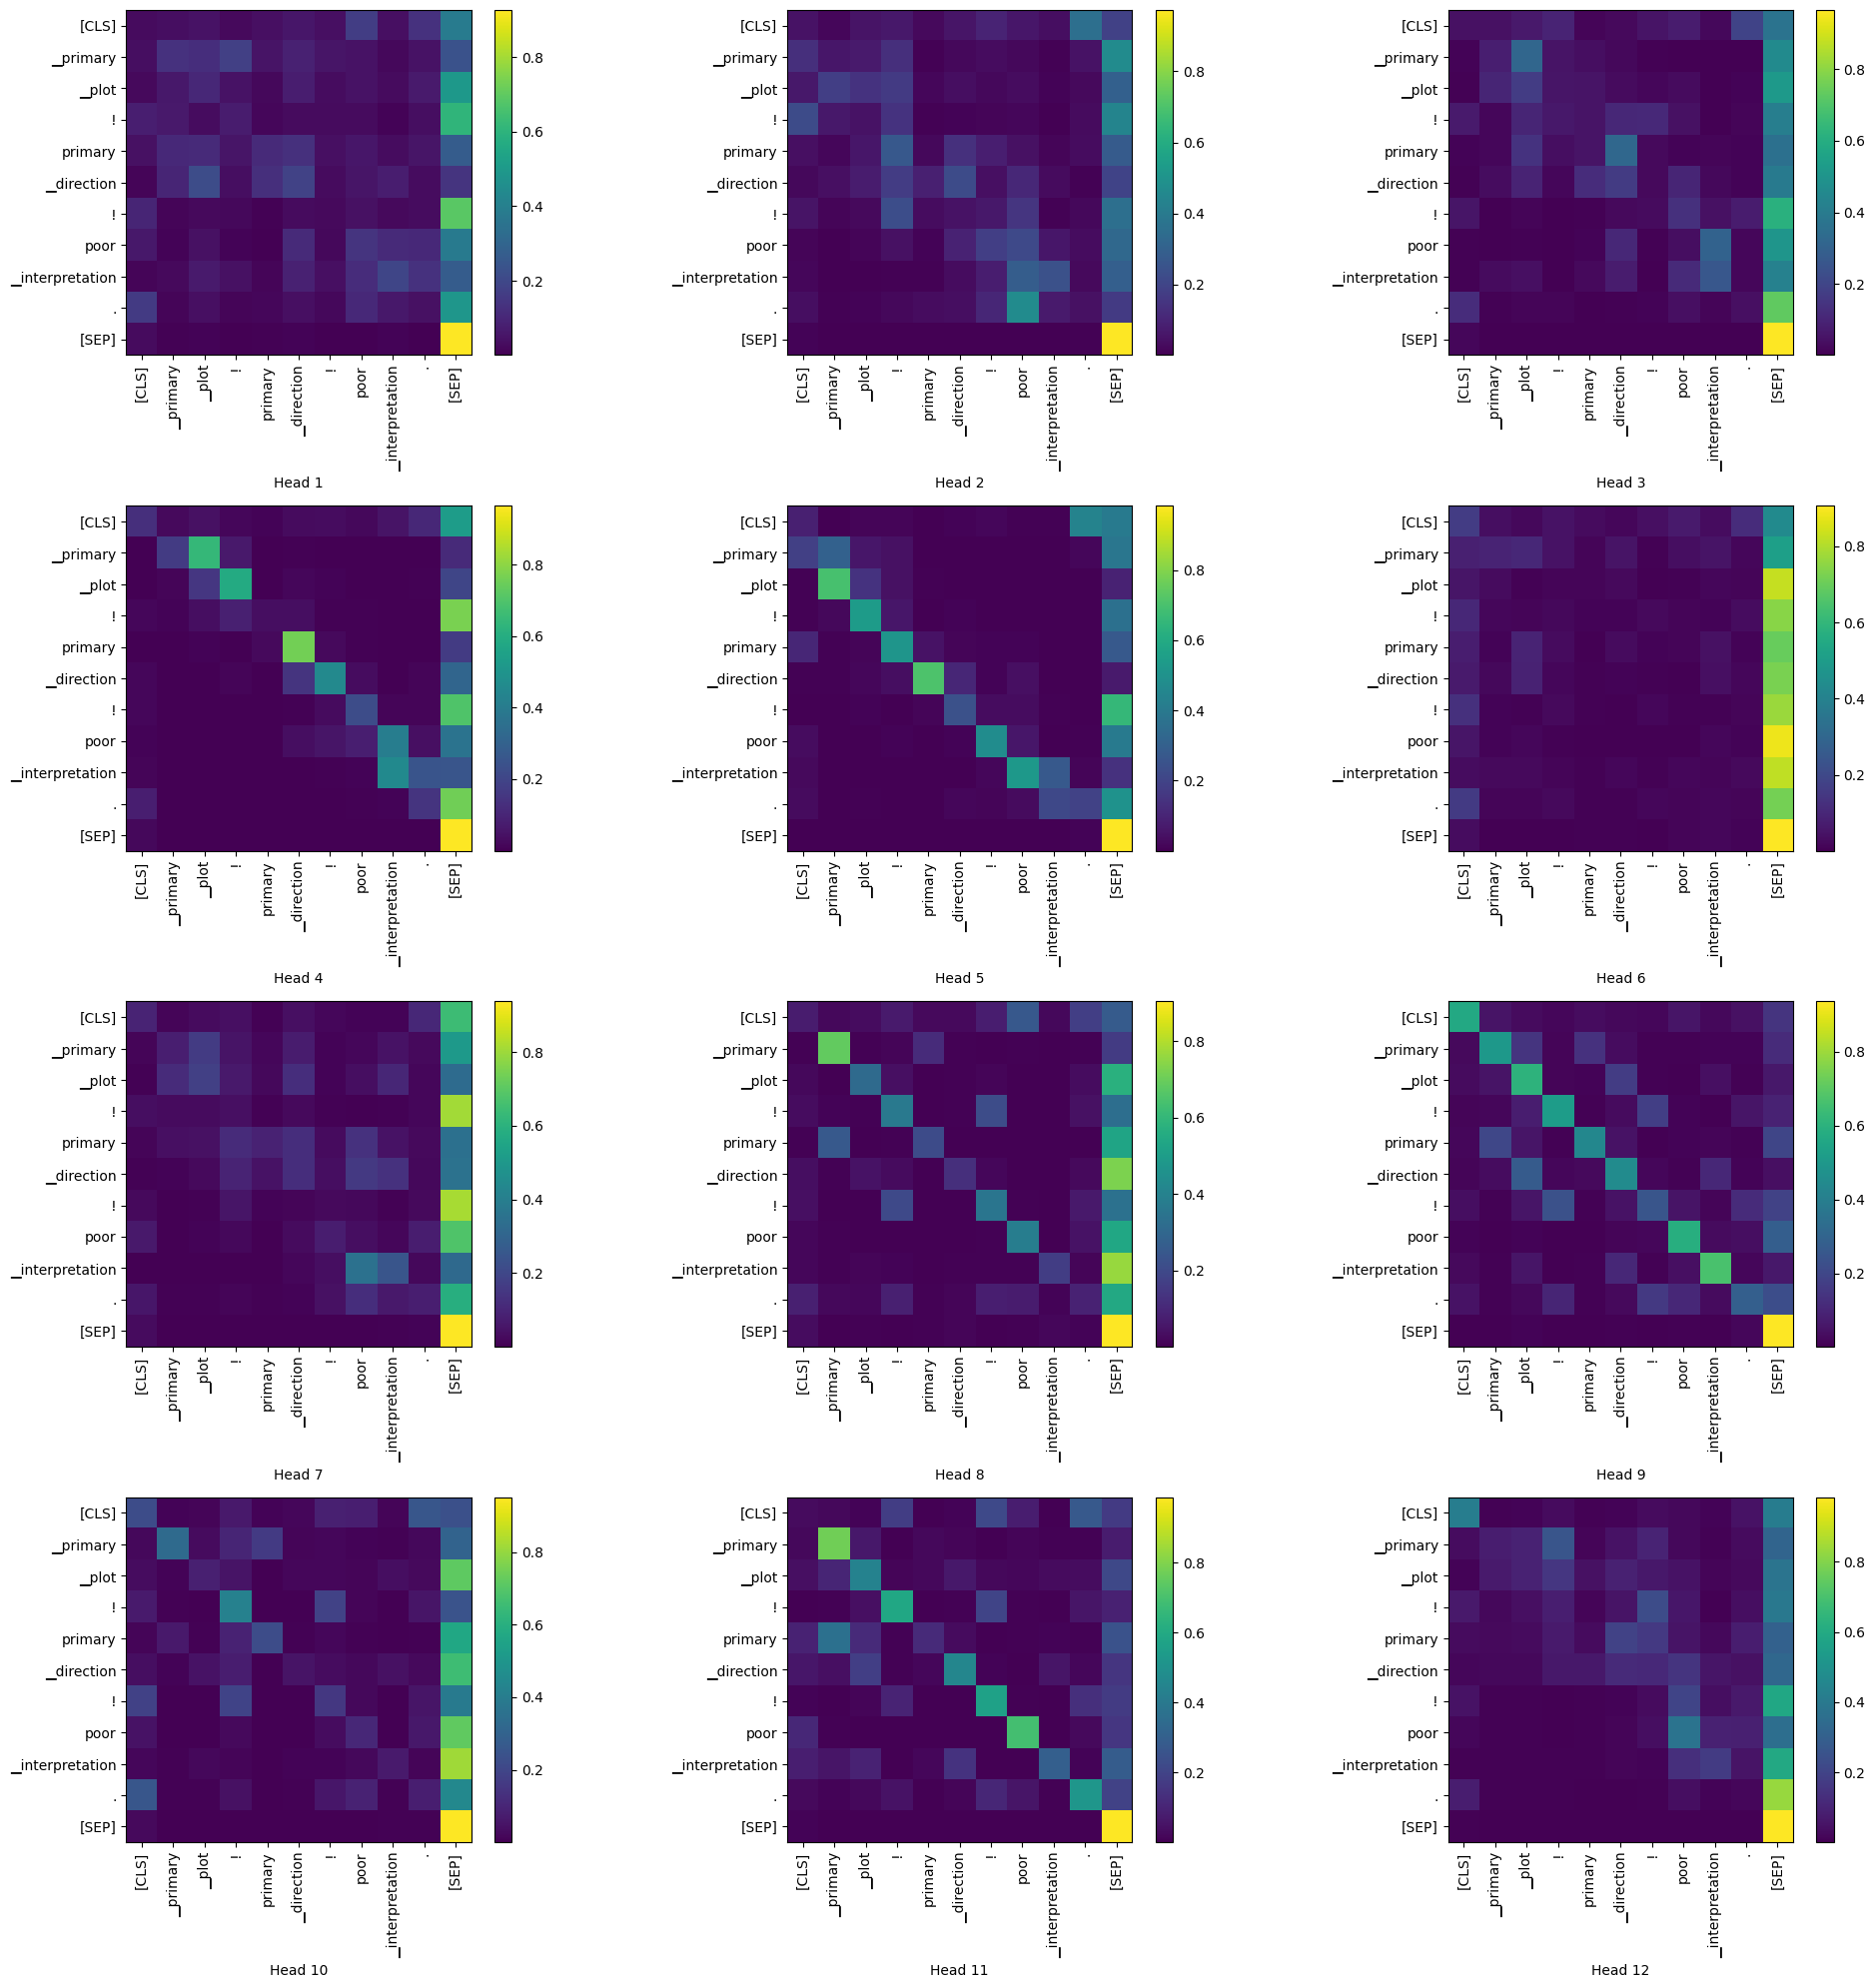

Incorrectly Classified Instance


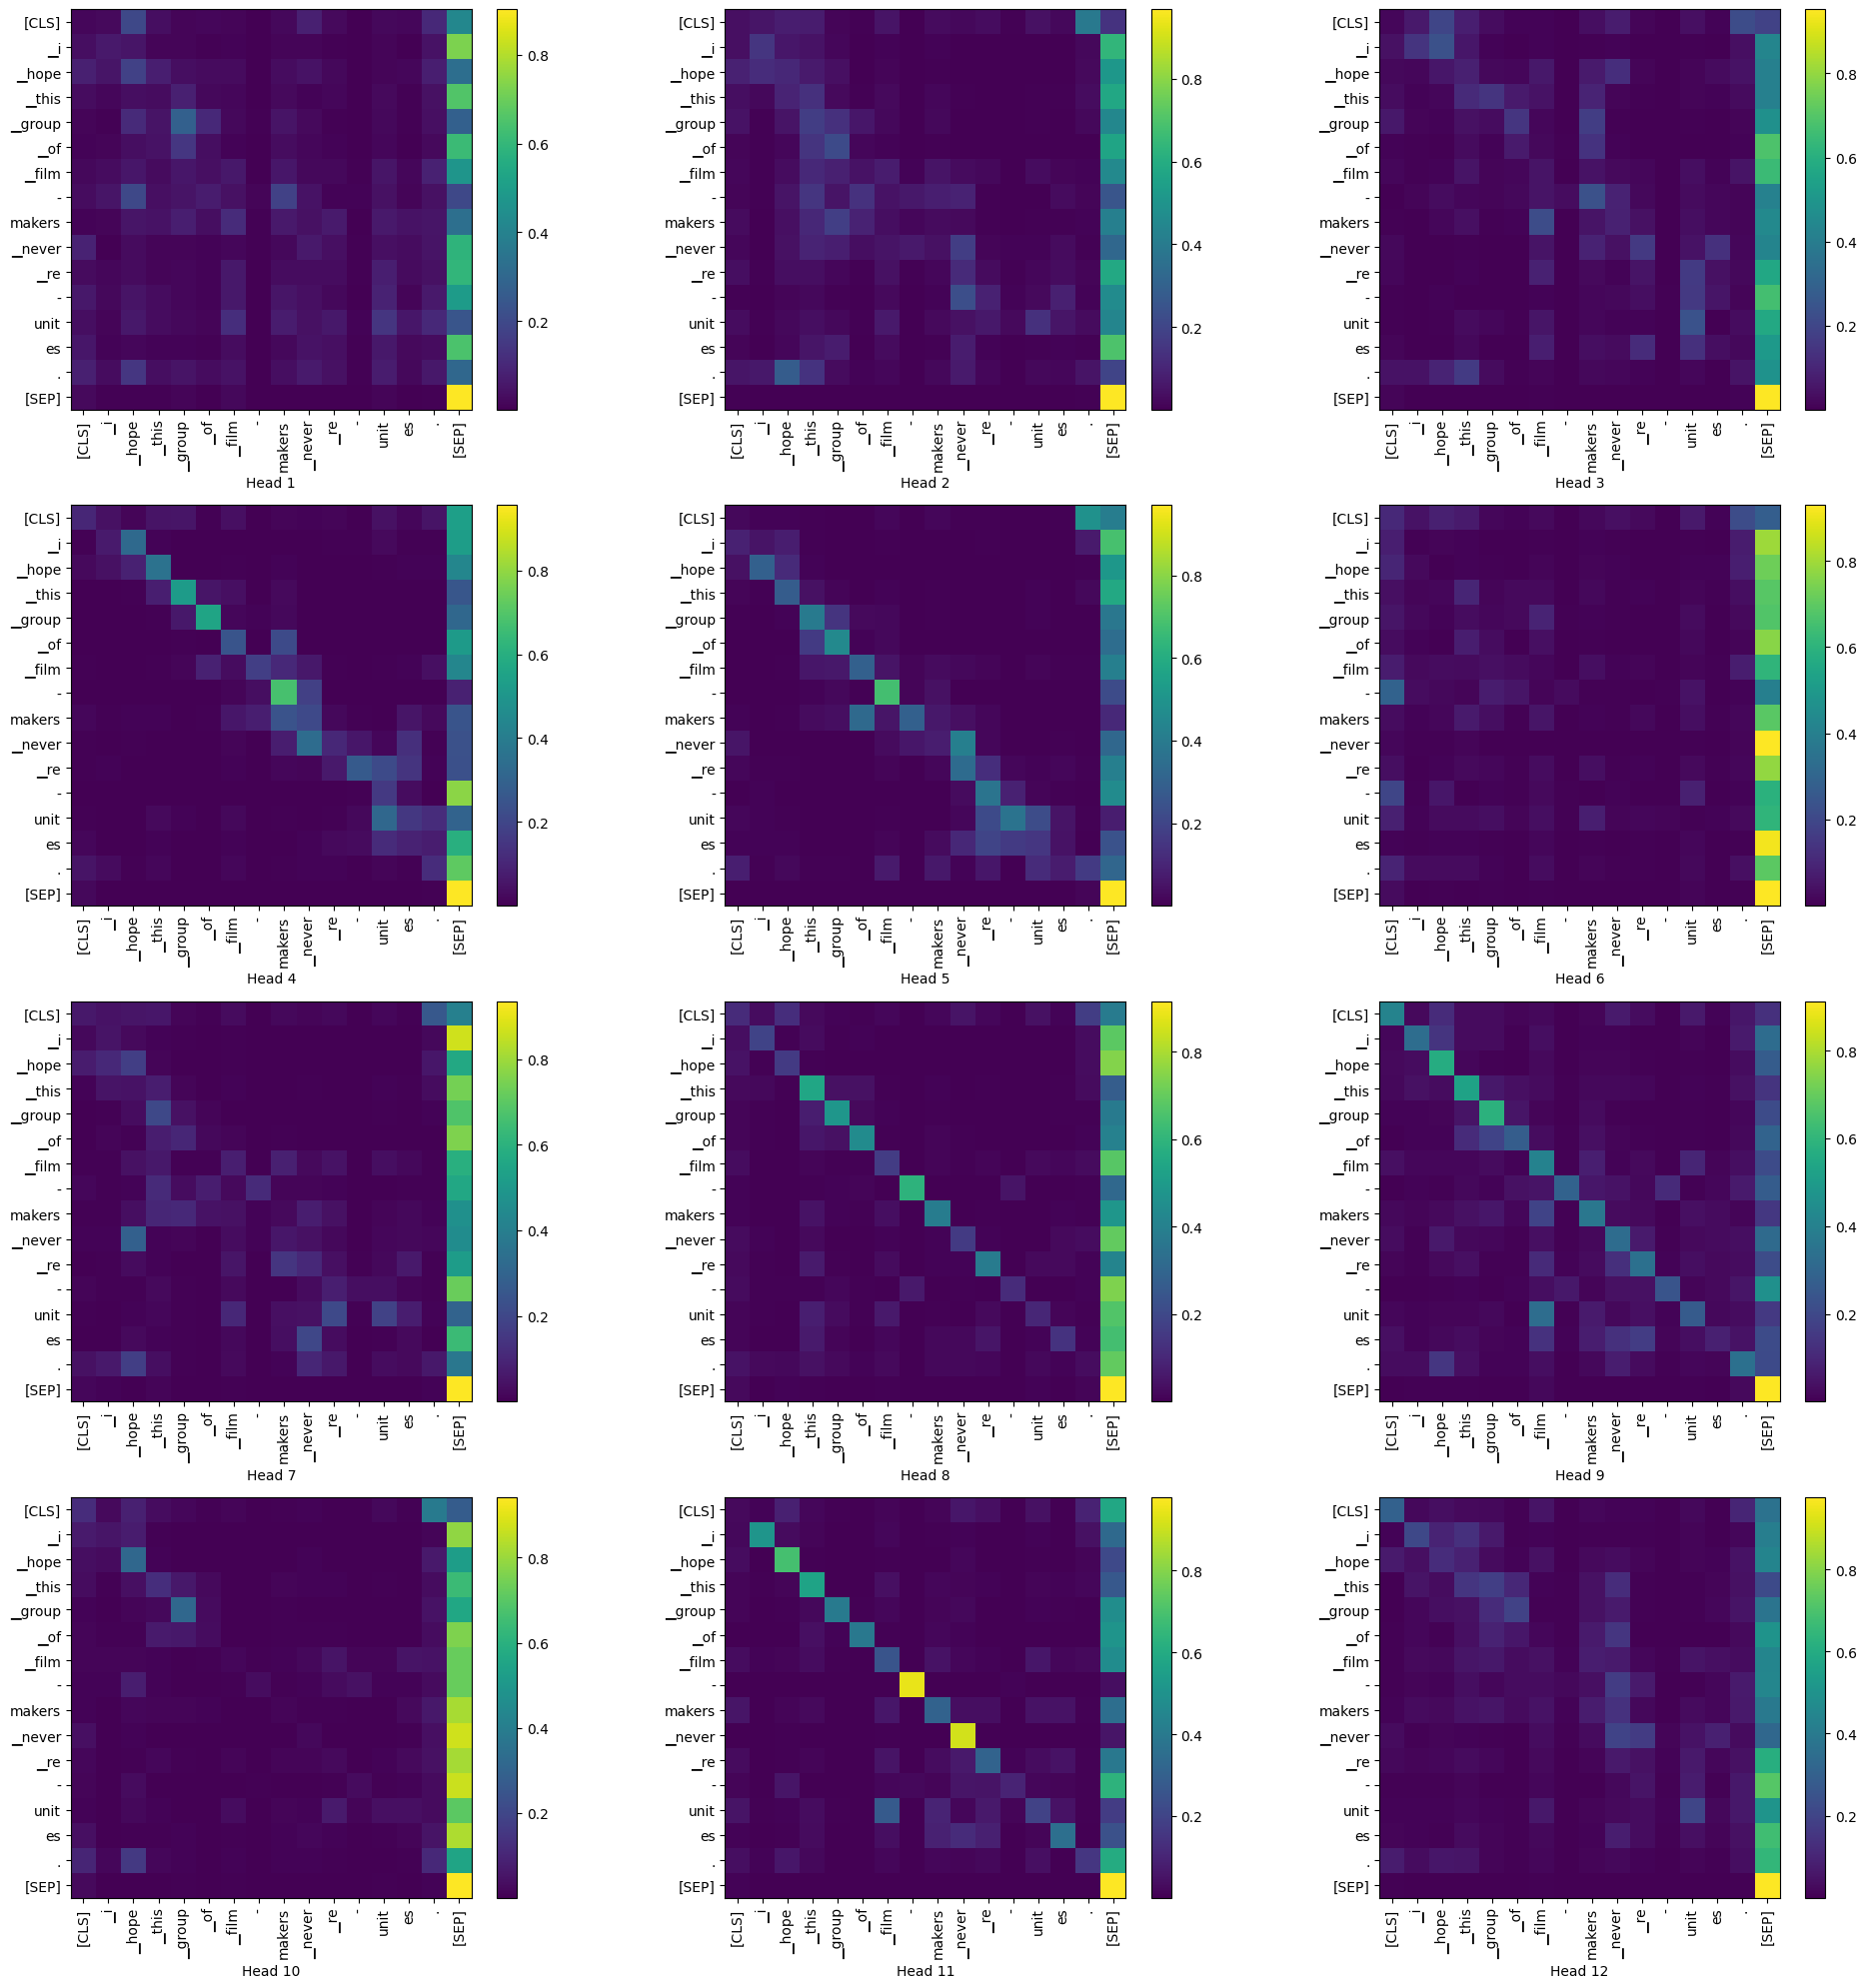

In [ ]:
print_attention_matrix(correctly_input, correctly_output, 'Correctly Classified Instance')
print_attention_matrix(incorrectly_input, incorrectly_output, 'Incorrectly Classified Instance')

## Task 4.5 - Not Working Experiment

We tried to add a Bidirectional LSTM Layer on top of ALBERT to improve performances. We could not do it. The following cells show the progress.

"BiLSTM is then concatenated at the very end of BERT, and it includes the dense layer. Therefore, BiLSTM receives information from BERT and feeds it into its dense layer, which then predicts respective classes for the input features. BERT and BiLSTM shared same hyperparameters, and we specify all hyperparameters in section 4 under experimental settings." https://scholarworks.uark.edu/cgi/viewcontent.cgi?article=6318&context=etd 
"The output from BERT should have same dimension as input to BiLSTM, which is set to 768 and is represented by C. On the same note, we only feed C to BiLSTM." 
"BiLSTM has one hidden component. The hidden state have input dimension of 128 by 256 by 768. 128 represents batch-size, 256 is time steps, and 768 represents number of units. Finally, there is a fully connected layer (dense layer) at the end, which has output dimension of batch-seize by 1, since we are working on binary classification."

In [ ]:
def build_ALBERT_BiLSTM_model(dropout_rate=0.1):
  movie_reviews = tf.keras.layers.Input(shape=(), dtype=tf.string, name='movie_reviews')
  preprocessor = hub.KerasLayer("http://tfhub.dev/tensorflow/albert_en_preprocess/3", name='preprocessor')
  encoder_inputs = preprocessor(movie_reviews)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3", trainable=True, name='encoder')
  outputs = encoder(encoder_inputs)
  # either pooled_output or sequence_output can be used for further model building
  pooled_output = outputs['pooled_output']
  # Add the BiLSTM layer
  # reshaped_output = tf.keras.layers.Reshape((128, 256, 768), name='reshape_1')(pooled_output) tf.reshape(pooled_output, shape=(128, 256, 768))
  biLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(728, return_sequences=True, name='LSTM'), name='Bidirectional')(pooled_output)
  # dropout_layer = tf.keras.layers.Dropout(dropout_rate, name='dropout')(pooled_output)
  # flattened_biLSTM = tf.keras.layers.Flatten()(biLSTM)
  classify_layer = tf.keras.layers.Dense(1, activation=None, name='binary_classifier')(biLSTM)
  # flattened_output = tf.keras.layers.Flatten()(classify_layer)
  # flattened_output = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=(1, 2)))(classify_layer)
  # reshaped_classification = tf.keras.layers.Reshape((1), name='reshape_2')(classify_layer)
  return tf.keras.Model(movie_reviews, classify_layer)

ALBERT_BiLSTM_model = build_ALBERT_BiLSTM_model()
ALBERT_BiLSTM_model.summary()
tf.keras.utils.plot_model(ALBERT_BiLSTM_model)

NameError: ignored

Compiling and Training ALBERT_BiLSTM

In [ ]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy = tf.metrics.BinaryAccuracy()
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)

# AdamW, Binary Cross Entropy, Accuracy
ALBERT_BiLSTM_model.compile(optimizer=optimizer,
                         loss=loss_function,
                         metrics=accuracy)
# training dataset, against validation dataset, number of epochs
history = ALBERT_BiLSTM_model.fit(x=training_dataset,
                               validation_data=validation_dataset,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 799s 1s/step - loss: 0.4171 - binary_accuracy: 0.7949 - val_loss: 0.3256 - val_binary_accuracy: 0.8248
Epoch 2/5
625/625 [==============================] - 744s 1s/step - loss: 0.2947 - binary_accuracy: 0.8722 - val_loss: 0.4675 - val_binary_accuracy: 0.6962
Epoch 3/5
625/625 [==============================] - 742s 1s/step - loss: 0.3538 - binary_accuracy: 0.8066 - val_loss: 0.6957 - val_binary_accuracy: 0.4990
Epoch 4/5
625/625 [==============================] - 739s 1s/step - loss: 0.4542 - binary_accuracy: 0.7426 - val_loss: 0.3814 - val_binary_accuracy: 0.8020
Epoch 5/5
 69/625 [==>...........................] - ETA: 10:11 - loss: 0.3449 - binary_accuracy: 0.8324

KeyboardInterrupt: ignored